In [20]:
# import standard modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (20, 10)

# Topic 4 - Parameter fitting

## Motivation

We again consider a simple empricial relation

$
y = a x + b + z
$

between the input $x$ and output of an experiment. Here $z$ denotes a random error with values
drawn from a zero-mean normal distribution. The code below generates a data set for us to work with. 

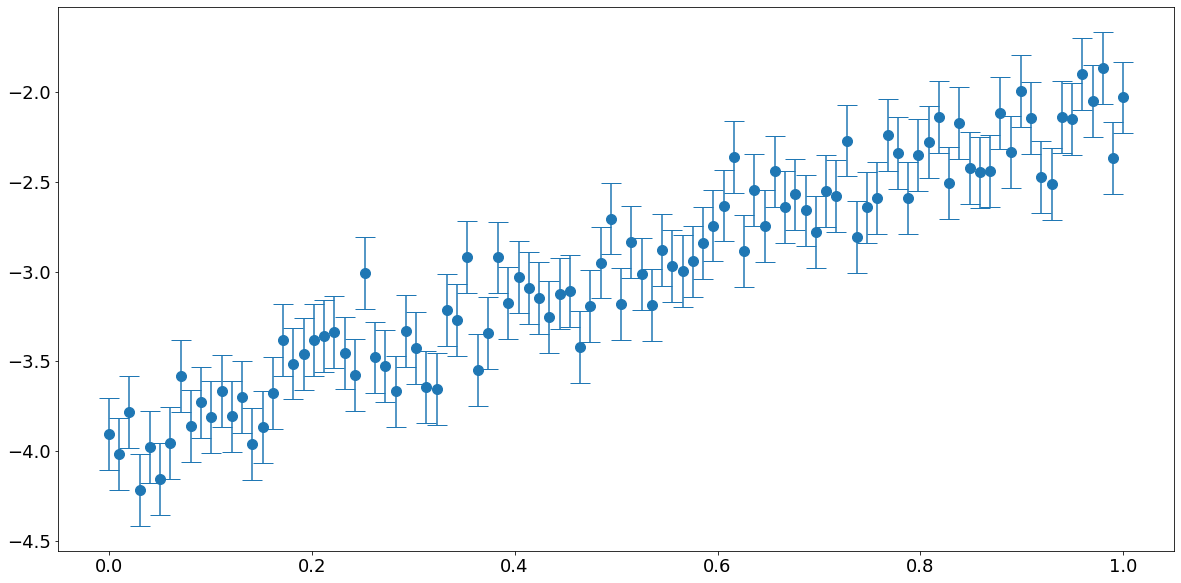

In [21]:
# Set the number of data
n = 100

# Set the true values for the parameters
a =  2
b = -4

# Set the values of x
x = np.linspace(0,1,n)

# Set the error distribution
sigma = 0.2
Z = stats.norm(scale = sigma)

# Get the values of y
y = a*x + b + Z.rvs(n)

# Plot the data
plt.errorbar(x,y,yerr=sigma,linestyle='none',marker='o',markersize = 10,capsize = 10)
plt.show()

As before, we forget that we know  the true values of $(a,b)$. We have seen how the viability of a proposed model can be *tested*. Building on this idea, we now ask how a suitable model can be *determined*. 

# Maximum likelihood estimates

Recall the normalised data residuals are defined by:


$
\bar{z}_{i} = \frac{ y_{i} - a x_{i} - b}{\sigma} 
$

If the parameters are correct, then these are samples drawn from a standard normal distribution. The PDF for such a distribtion is given by


$
p(z) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{-z^{2}}{2}
\right).
$

By assumption, the values of the $\bar{z}_{i}$ are indepedent, and hence their joint PDF is

$
p(z_{1},\dots,z_{n}) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{-z_{1}^{2}}{2}\right) \times
\cdots \times \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{-z_{n}^{2}}{2}\right)
 = \frac{1}{\sqrt{(2\pi)^{n}}}\exp\left(
 -\frac{1}{2}\sum_{i=1}^{n} z_{i}^{2}
 \right).
$

If we put the observed values of the data residuals into this PDF, we find

$
p(\bar{z}_{1},\dots,\bar{z}_{n}) = \frac{1}{\sqrt{(2\pi)^{n}}}\exp\left(
 -\frac{1}{2}\sum_{i=1}^{n} \bar{z}_{i}^{2}
 \right) = \frac{1}{\sqrt{(2\pi)^{n}}}\exp\left(
 -\frac{1}{2}\chi^{2}
 \right),
$

where we have used the definition of the $\chi^{2}$ statistic. This value depends on the 
chosen model parameters, and hence we can equivalently write

$
L(a,b) = p(\bar{z}_{1},\dots,\bar{z}_{n}) =  \frac{1}{\sqrt{(2\pi)^{n}}}\exp\left[
 -\frac{1}{2}\sum_{i=1}^{n} \left(\frac{ y_{i} - a x_{i} - b}{\sigma} \right)^{2}
 \right], 
$

which is known as the **likelihood**. Within the **maximum likelihood method**, we seek
model parameters that maximise this function. This is equivalent to minimising the **negative log-likelihood**
which is defined to be

$
l(a,b) = - \ln L(a,b), 
$

which is a simple quadratic function of the model parameters. We can find the desired
minimum value by setting the derivatives of $l$ with respect to $a$ and $b$ equal to zero. It is a matter
of simple algebra to show that the optimal values are

$
a = \frac{\sum_{i=1}^{n} (x_{i} - \bar{x})(y_{i}-\bar{y})}{\sum_{i=1}^{n} (x_{i}-\bar{x})^{2}}, \\
b = \sum_{i=1}^{n}(y_{i}-a x_{i}), 
$

where $\bar{x}$ and $\bar{y}$ denote arithmetic averages. The code below computes the
maximum likelihood estimate from our data:

optimal values are: a =  1.9440, b = -3.9679


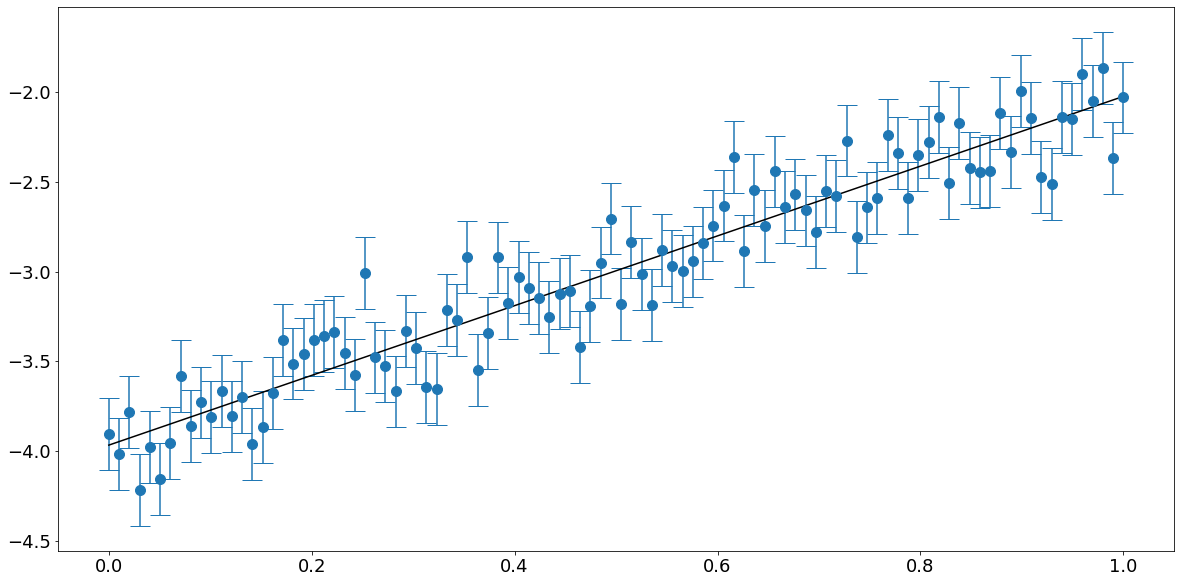

In [22]:
# Compute optimal values for the model parameters
xbar = np.average(x)
ybar = np.average(y)
a = np.sum( (x - xbar) * (y - ybar)) / np.sum( (x-xbar)**2)
b = ybar - a*xbar
print("optimal values are: a = %7.4f, b = %7.4f" % (a,b))

# Plot the results
xx = np.linspace(0,1,100)
yy = a*xx+b
plt.errorbar(x,y,yerr=sigma,linestyle='none',marker='o',markersize = 10,capsize = 10)
plt.plot(xx,yy,'k')
plt.show()

Visually, the line produced seems to fit the data well. But what we should really do is perform a suitable hypothesis test to see if the model is acceptable. This is done in the code below using the 
chi-squared test discussed within Topic 3:

In [23]:
# compute the normalised residuals for the proposed model
z = (y - a*x - b)/sigma

# Compute the value of chi2 from the data
chi2 = np.sum(z*z)

# Compute the p-value
Chi2 = stats.chi2(n)
pv = 1 - Chi2.cdf(chi2)
print("p-value = %7.4f" % pv)

p-value =  0.9343


Looking at the p-value, we see that this model would be accepted for any sensible choice of significance level. 

The application of the maximum likelihood method discussed here is very simple. But the basic idea can be addapted to problems involving more parameters, with a more complicated functional form,  and with different error distributions. In such cases, it may then be necessary to solve a non-linear optimisation problem using numerical techniques. But there exist a range of open-source methods for doing this. 


## Estimating uncertainties on the model parameters

We have now seen that the maximum likelihood method can produce values of the model parameters that explain the observed data. In practice, however, there will be a range of possible answers that could be accepted, and this range should be quantified.  Suppose, for definiteness, 
we wish to determine the range of possible values for the slope, $a$, within our model. To do this, we can 
combine the methods developed so far in the following manner:

1. Choose a critical probability, $p_{c}$, for the test.
2. For a proposed value of $a$, we can seek the value of $b$ that minimises the chi-squared statistic.
3. For the model obtained, we conduct a chi-squared test. 
4. Select another value of $a$ and repeat the process. 

In this manner, we can map out all plausible slopes. The code below shows how this can be done in practice.  

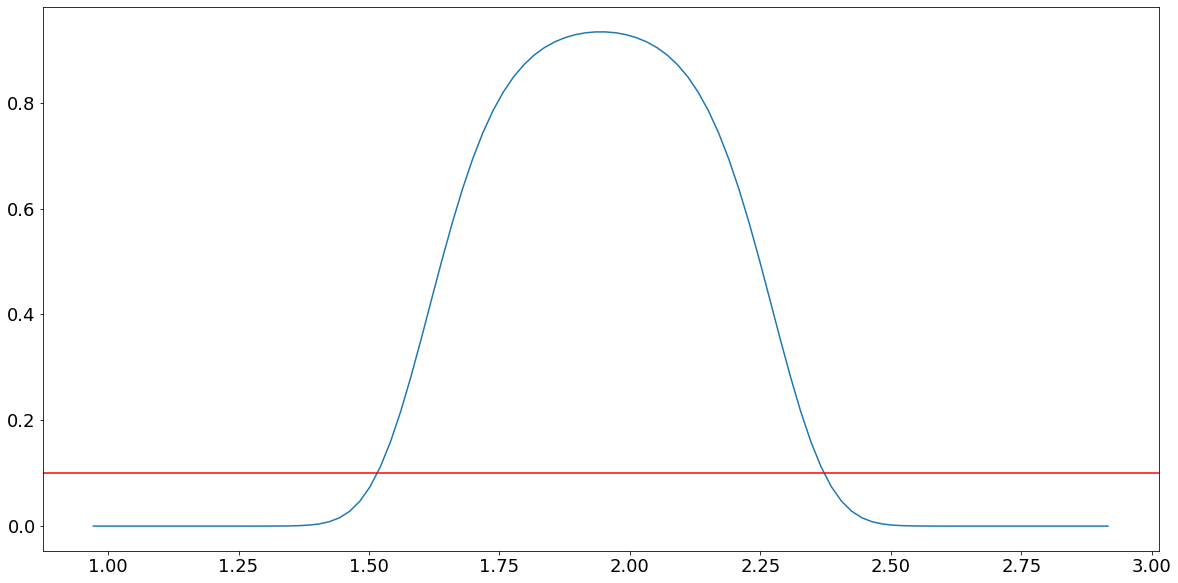

In [29]:
# Set the critical probability.
pc = 0.1

# Define a function that solves for the optimal value of b 
def FindOptimalIntercept(x,y,a):
    return np.sum(y-a*x)/x.size

# Use the maximum likelihood soltution to propose a sensible range of slopes to test
f = 0.5
a1 = (1-f)*a
a2 = (1+f)*a
nSlopes = 100
aa = np.linspace(a1,a2,nSlopes)

# For each slope compute a p-value
pp = np.zeros(nSlopes)
for i in range(nSlopes):
    b = FindOptimalIntercept(x,y,aa[i])
    z = (y- aa[i] * x-b) / sigma
    chi2 = np.sum(z*z)
    Chi2 = stats.chi2(n)
    pp[i] = 1 - Chi2.cdf(chi2)
    
# Plot the p-values as a function of the slope and showing the critical value. 
plt.plot(aa,pp)
plt.axhline(y = pc, color = 'r')
plt.show()

The plausible values for $a$ within this plot are those for which the $p$-values (shown in blue) lie above the critical value (shown in red).